In [1]:
import json

import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

%matplotlib inline

### Load

Load the original dataset

In [2]:
col_names = ["image_path", "bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class_name"]
df_train = pd.read_csv("ankle_bones_dataset/annotations.csv", names=col_names, header=None)
df_val = pd.read_csv("ankle_bones_dataset/validations.csv", names=col_names, header=None)
df_classes = pd.read_csv("ankle_bones_dataset/classes.csv", names=["name", "id"], header=None, index_col="id")

print("Train size:", df_train.shape)
print("Val size:", df_val.shape)

df_train.head()

Train size: (2546, 6)
Val size: (1134, 6)


,image_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_name
0,images/hggg_08.jpg,77,53,119,88,Goat
1,images/hggg_08.jpg,112,100,147,128,Goat
2,images/hggg_08.jpg,130,131,178,174,Goat
3,images/ccss_08.jpg,142,73,178,104,Sheep
4,images/ccss_08.jpg,170,113,205,151,Sheep


Concat to fix the splitting issue

In [3]:
df_data =pd.concat([df_train, df_val])
df_data["class_name"] = df_data["class_name"].str.lower()

print(df_data.shape)
df_data.head()

(3680, 6)


,image_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_name
0,images/hggg_08.jpg,77,53,119,88,goat
1,images/hggg_08.jpg,112,100,147,128,goat
2,images/hggg_08.jpg,130,131,178,174,goat
3,images/ccss_08.jpg,142,73,178,104,sheep
4,images/ccss_08.jpg,170,113,205,151,sheep


### Classes
ids, names, colors

In [4]:
id_to_class = {k: v["name"].lower() for k, v in df_classes.to_dict(orient="index").items()}
class_to_id = {v: k for k, v in id_to_class.items()}
id_to_class, class_to_id

({0: 'horse', 1: 'camel', 2: 'sheep', 3: 'goat'},
 {'horse': 0, 'camel': 1, 'sheep': 2, 'goat': 3})

In [5]:
cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, len(class_to_id.keys())))
# 0-1 to 0-255 and dtype to uint8
colors = (colors[:,:3] * 255).astype(np.uint8).tolist()
colors

[[12, 7, 134], [155, 23, 158], [236, 120, 83], [239, 248, 33]]

In [6]:
for i, c in id_to_class.items():
    df_data.loc[df_data["class_name"] == c, "class_id"] = i
df_data["class_id"] = df_data["class_id"].astype(int)
df_data.head()

,image_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_name,class_id
0,images/hggg_08.jpg,77,53,119,88,goat,3
1,images/hggg_08.jpg,112,100,147,128,goat,3
2,images/hggg_08.jpg,130,131,178,174,goat,3
3,images/ccss_08.jpg,142,73,178,104,sheep,2
4,images/ccss_08.jpg,170,113,205,151,sheep,2


### Process

Group dataset by image_path to restructure the dataset to a new format.

In [7]:
df_data_grouped = (
    df_data.groupby("image_path")
    .apply(
        lambda x: x[["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class_id"]].to_dict(
            "records"
        )
    )
    .reset_index(name="bboxes")
)

print(df_data.shape)
df_data_grouped.head()

(3680, 7)


/var/folders/14/k58yfw1j045_qtfckc1fqjbw0000gn/T/ipykernel_31055/3668168937.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,image_path,bboxes
0,images/a_img_001.jpg,"[{'bbox_x1': 138, 'bbox_y1': 122, 'bbox_x2': 1..."
1,images/a_img_002.jpg,"[{'bbox_x1': 109, 'bbox_y1': 74, 'bbox_x2': 14..."
2,images/a_img_003.jpg,"[{'bbox_x1': 115, 'bbox_y1': 103, 'bbox_x2': 1..."
3,images/a_img_004.jpg,"[{'bbox_x1': 145, 'bbox_y1': 41, 'bbox_x2': 18..."
4,images/a_img_005.jpg,"[{'bbox_x1': 95, 'bbox_y1': 35, 'bbox_x2': 138..."


#### Visualize the sample data

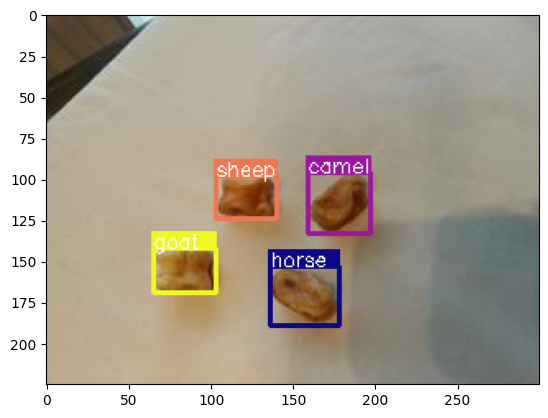

In [8]:
sample_data = df_data_grouped.iloc[123]
sample_bboxes = sample_data["bboxes"]
image = cv2.imread("ankle_bones_dataset/" + sample_data["image_path"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for bbox in sample_bboxes:
    x1, y1 = bbox["bbox_x1"], bbox["bbox_y1"]
    x2, y2 = bbox["bbox_x2"], bbox["bbox_y2"]

    box_color = colors[bbox["class_id"]]
    cv2.rectangle(image, (x1, y1), (x2, y2), box_color, 2)
    cv2.rectangle(image, (x1 - 1, y1), (x2, y1 - 10), box_color, -1)
    cv2.putText(
        image,
        id_to_class[bbox["class_id"]],
        (x1, y1),
        fontScale=0.4,
        color=(255, 255, 255),
        thickness=1,
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    )

plt.imshow(image)
plt.show()

### Save the dataset in a new format

In [9]:
coco_metadata = {
    "info": {
        "year": 2018,
        "version": "1.0",
        "description": "Object detection dataset for identifying the shape of shagai (sheep ankle bone)",
        "contributor": "Bilguun Ochirbat, Amarsaikhan Batjargal, Bandikhuu Baasanjav",
        "url": "https://github.com/bilguun0203/ankle-bone-recognition",
        "date_created": "2018/07/11",
    },
    "licenses": [
        {
            "id": 1,
            "name": "CC BY-NC",
            "url": "https://creativecommons.org/licenses/by-nc/4.0/",
        }
    ],
}

In [10]:
coco_data = {
    **coco_metadata,
    "categories": [],
    "images": [],
    "annotations": [],
}


for i, c in id_to_class.items():
    coco_data["categories"].append(
        {
            "id": i,
            "name": c,
        }
    )

annotation_id = 1
for idx, row in df_data_grouped.iterrows():
    image_path = row["image_path"]
    image_id = idx + 1

    # Get image dimensions
    img = cv2.imread("ankle_bones_dataset/" + image_path)
    height, width = img.shape[:2]

    # Add image info
    coco_data["images"].append(
        {
            "id": image_id,
            "file_name": image_path,
            "width": width,
            "height": height,
            "license": 1,
            "date_captured": "2018-07-11 08:00:00",
        }
    )

    for bbox in row["bboxes"]:
        # COCO format uses [x, y, width, height] where (x,y) is the top-left corner
        x1, y1 = bbox["bbox_x1"], bbox["bbox_y1"]
        x2, y2 = bbox["bbox_x2"], bbox["bbox_y2"]
        width = x2 - x1
        height = y2 - y1

        coco_data["annotations"].append(
            {
                "id": annotation_id,
                "image_id": image_id,
                "category_id": bbox["class_id"],
                "bbox": [x1, y1, width, height],
                "area": width * height,
                "segmentation": [],
                "iscrowd": 0,
            }
        )
        annotation_id += 1

Save COCO formatted dataset to a json file

In [11]:
with open("ankle_bones_dataset/annotations.json", "w") as f:
    json.dump(coco_data, f)

### Create split dataset

In [12]:
train_ids, valid_ids = train_test_split([img["id"] for img in coco_data["images"]], test_size=0.3, random_state=123)
print("Train:", len(train_ids))
print("Valid:", len(valid_ids))

Train: 644
Valid: 277


In [13]:
train_data = {
    **coco_metadata,
    "categories": coco_data["categories"],
    "images": [image for image in coco_data["images"] if image["id"] in train_ids],
    "annotations": [ann for ann in coco_data["annotations"] if ann["image_id"] in train_ids],
}
valid_data = {
    **coco_metadata,
    "categories": coco_data["categories"],
    "images": [image for image in coco_data["images"] if image["id"] in valid_ids],
    "annotations": [ann for ann in coco_data["annotations"] if ann["image_id"] in valid_ids],
}

In [14]:
train_classes_count = {0:0, 1:0, 2:0, 3:0}
valid_classes_count = {0:0, 1:0, 2:0, 3:0}

for ann in train_data["annotations"]:
    train_classes_count[ann["category_id"]] += 1
for ann in valid_data["annotations"]:
    valid_classes_count[ann["category_id"]] += 1

print(f"Training data: {len(train_data['images'])} images, {len(train_data['annotations'])} objects")
print(f"\tclasses: {train_classes_count}")
print(f"Validation data: {len(valid_data['images'])} images, {len(valid_data['annotations'])} objects")
print(f"\tclasses: {valid_classes_count}")


Training data: 644 images, 2573 objects
	classes: {0: 644, 1: 642, 2: 668, 3: 619}
Validation data: 277 images, 1107 objects
	classes: {0: 302, 1: 245, 2: 281, 3: 279}


In [15]:
with open("ankle_bones_dataset/train/annotations.json", "w") as f:
    json.dump(train_data, f)
with open("ankle_bones_dataset/valid/annotations.json", "w") as f:
    json.dump(valid_data, f)

In [16]:
import shutil

for image in train_data["images"]:
    shutil.copy2(
        "ankle_bones_dataset/" + image["file_name"],
        "ankle_bones_dataset/train/" + image["file_name"],
    )
for image in valid_data["images"]:
    shutil.copy2(
        "ankle_bones_dataset/" + image["file_name"],
        "ankle_bones_dataset/valid/" + image["file_name"],
    )